In [96]:
import numpy as np
import pandas as pd

In [97]:
#import data
data=pd.read_csv("data/crypto_2y.csv")
data.head()

,time,BTC,ETH,XRP,BCH,USDT,LTC,EOS
0,2018-04-22 01:00:00,8842.55,596.51,0.8486,1136.34,1.0,145.58,10.85
1,2018-04-22 02:00:00,8874.40,602.74,0.8509,1137.98,1.0,146.38,11.15
2,2018-04-22 03:00:00,8845.22,600.79,0.8502,1128.77,1.0,146.26,11.16
3,2018-04-22 04:00:00,8865.49,604.87,0.8563,1137.97,1.0,146.38,11.37
4,2018-04-22 05:00:00,8859.59,606.72,0.8584,1139.97,1.0,147.31,11.39


In [98]:
# transform the datetime
data['time']=pd.to_datetime(data.time,format="%Y-%m-%d %H:%M:%S")
data=data.set_index(['time'])
data.head()

,BTC,ETH,XRP,BCH,USDT,LTC,EOS
time,,,,,,,
2018-04-22 01:00:00,8842.55,596.51,0.8486,1136.34,1.0,145.58,10.85
2018-04-22 02:00:00,8874.40,602.74,0.8509,1137.98,1.0,146.38,11.15
2018-04-22 03:00:00,8845.22,600.79,0.8502,1128.77,1.0,146.26,11.16
2018-04-22 04:00:00,8865.49,604.87,0.8563,1137.97,1.0,146.38,11.37
2018-04-22 05:00:00,8859.59,606.72,0.8584,1139.97,1.0,147.31,11.39


## ARIMA

In [99]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Stationary

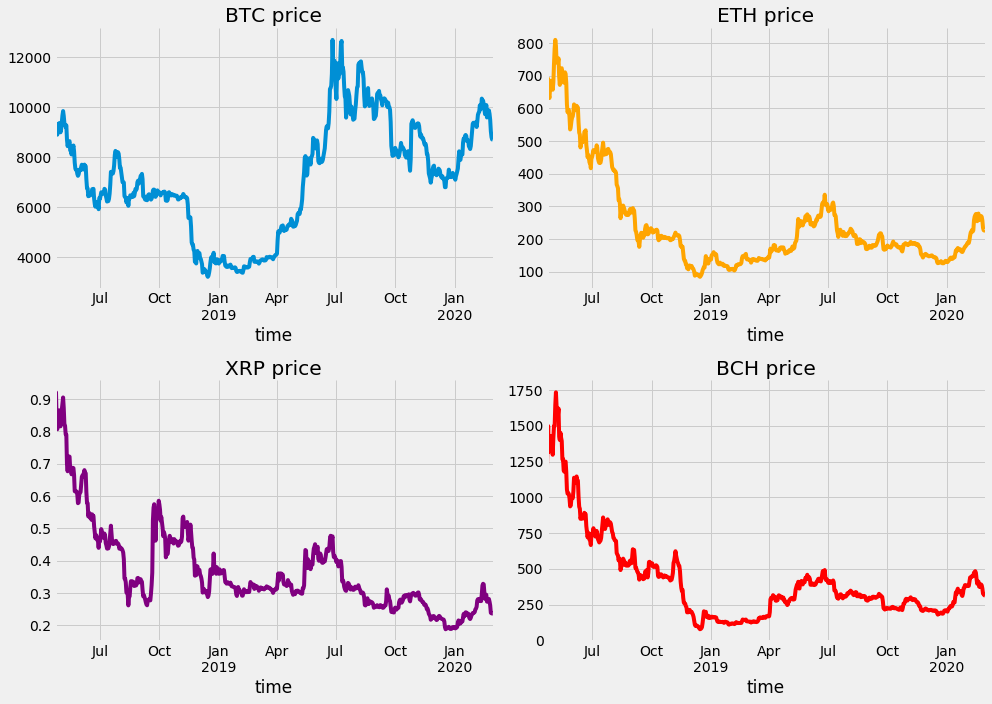

In [100]:
def originplot(data,figsize=(14,10)):
    fig=plt.figure(figsize=figsize)
    layout=(2,2)
    btcday_ax=plt.subplot2grid(layout,(0,0)) 
    ethday_ax=plt.subplot2grid(layout,(0,1))
    xrpday_ax=plt.subplot2grid(layout,(1,0)) 
    bchday_ax=plt.subplot2grid(layout,(1,1)) 
    
    btc_day=data['BTC'].resample('D').mean()
    btc_train=btc_day['20180422':'20200229']
    btc_train.plot(ax=btcday_ax)
    btcday_ax.set_title("BTC price")

    eth_day=data['ETH'].resample('D').mean()
    eth_train=eth_day['20180422':'20200229']
    eth_train.plot(ax=ethday_ax,color="orange")
    ethday_ax.set_title("ETH price")

    xrp_day=data['XRP'].resample('D').mean()
    xrp_train=xrp_day['20180422':'20200229']
    xrp_train.plot(ax=xrpday_ax,color="purple")
    xrpday_ax.set_title("XRP price")
    
    bch_day=data['BCH'].resample('D').mean()
    bch_train=bch_day['20180422':'20200229']
    bch_train.plot(ax=bchday_ax,color="red")
    bchday_ax.set_title("BCH price")
    
    sns.despine()
    fig.tight_layout()
    return btc_train,eth_train,xrp_train,bch_train

btc_train,eth_train,xrp_train,bch_train=originplot(data)

## XRP

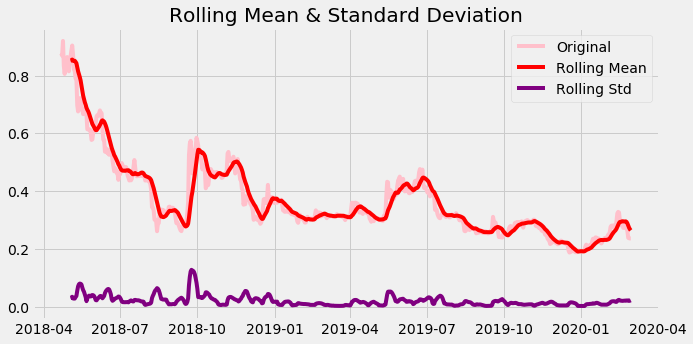

Results of Augment Dickey-Fuller Test:
Test Statistic                  -3.677020
p-value                          0.004448
#Lags Used                       6.000000
Number of Observations Used    672.000000
Critical Value (1%)             -3.440119
Critical Value (5%)             -2.865851
Critical Value (10%)            -2.569066
dtype: float64


In [101]:
def rolling_statistics(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    orig = plt.plot(timeseries, color='pink',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='purple', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
#adf test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    plt.figure(figsize=(10,5))
    rolling_statistics(timeseries)
    print('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
adf_test(xrp_train)

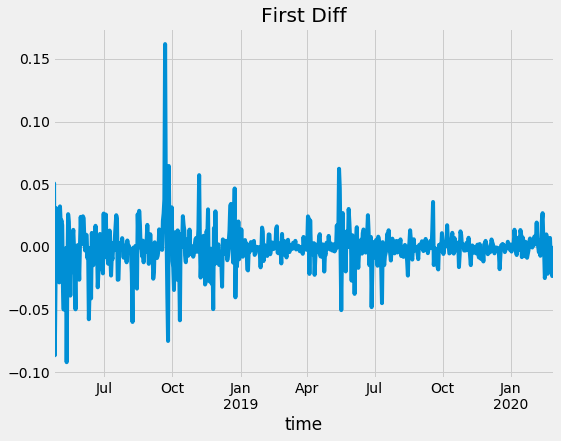

In [102]:
#Fist diff
xrp_diff=xrp_train.diff()
xrp_diff=xrp_diff.dropna()

plt.figure()
xrp_diff.plot(figsize=(8,6))
plt.title("First Diff")
plt.show()

Text(0.5, 1.0, 'PACF')

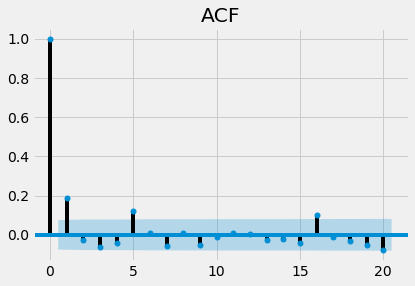

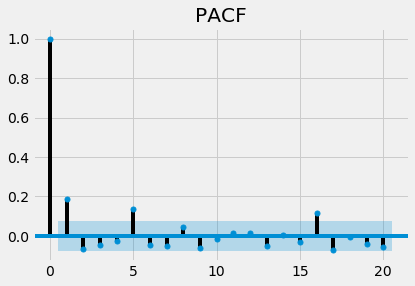

In [103]:
#ACF/PACF 
xrp_acf=plot_acf(xrp_diff,lags=20)
plt.title("ACF")

xrp_pacf=plot_pacf(xrp_diff,lags=20)
plt.title("PACF")

In [104]:
#ARIMA
model=sm.tsa.statespace.SARIMAX(xrp_train, order=(1,1,1))
result=model.fit()

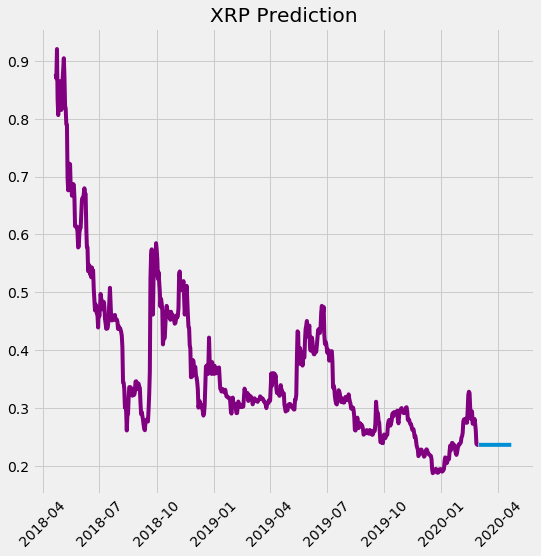

In [105]:
#prediction
pred=result.predict('20200301','20200422',dynamic=True,typ='levels')
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
plt.title("XRP Prediction")
plt.plot(pred)
plt.plot(xrp_train,color="purple")

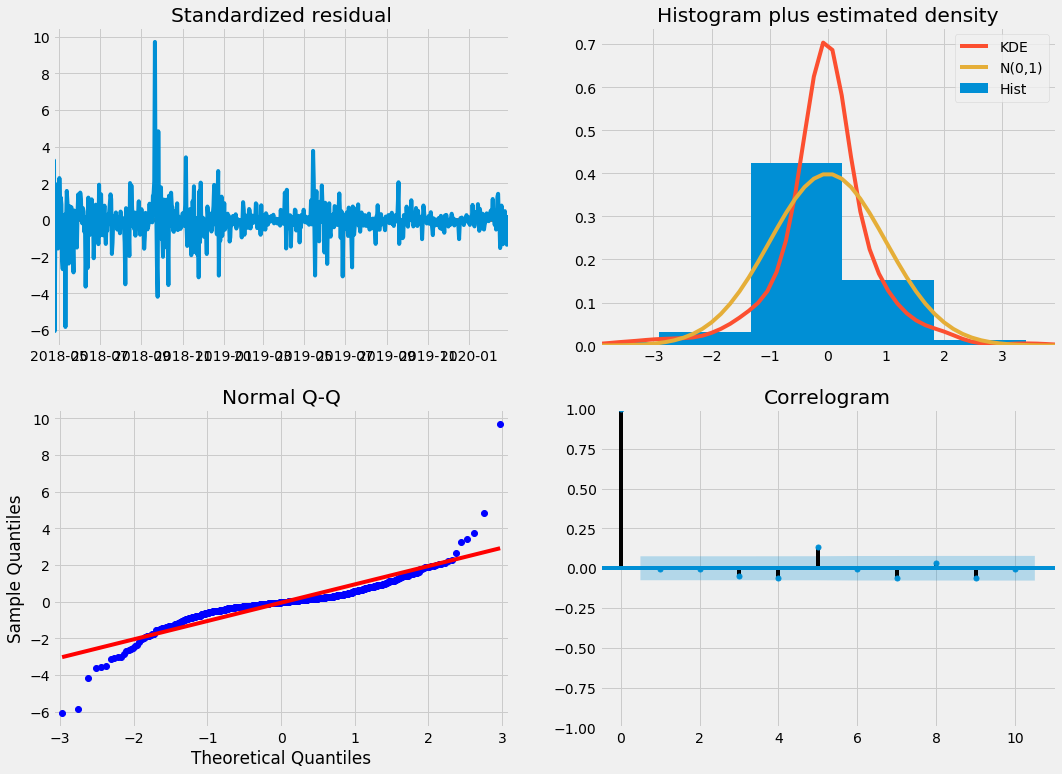

In [106]:
#residual analysis
result.plot_diagnostics(figsize=(16,12))
plt.show()

In [107]:
pred = result.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

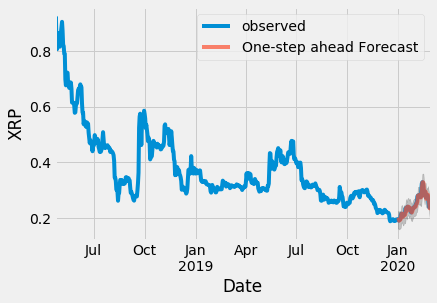

In [108]:
ax = xrp_train['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('XRP')
plt.legend()

plt.show()

In [109]:
y_forecasted = pred.predicted_mean
y_truth = xrp_train['2018':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
mse

7.854575750346999e-05

## BTC

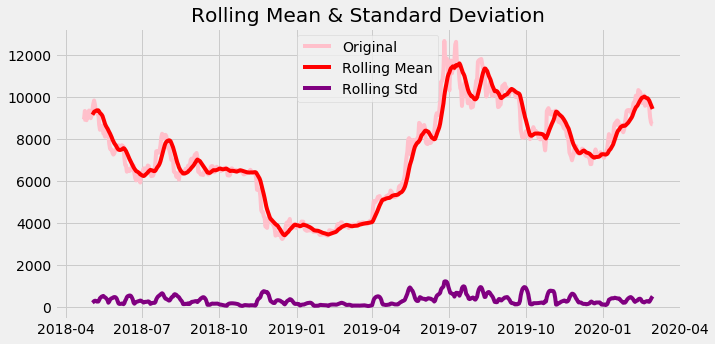

Results of Augment Dickey-Fuller Test:
Test Statistic                  -1.608397
p-value                          0.479374
#Lags Used                       3.000000
Number of Observations Used    675.000000
Critical Value (1%)             -3.440075
Critical Value (5%)             -2.865831
Critical Value (10%)            -2.569055
dtype: float64


In [110]:
#adf test
adf_test(btc_train)

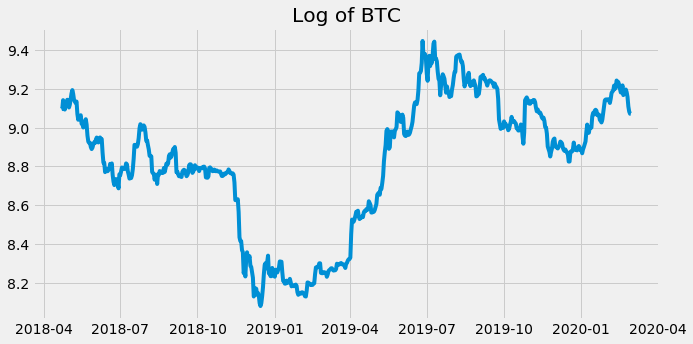

In [111]:
#get log
btc_log=np.log(btc_train)
plt.figure(figsize=(10,5))
plt.title("Log of BTC")
plt.plot(btc_log)

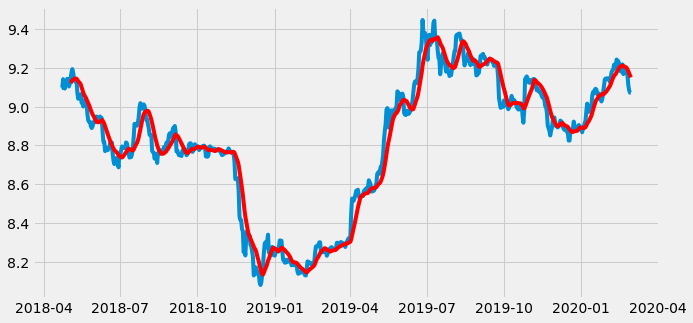

In [112]:
#roll average
moving_avg = btc_log.rolling(12).mean()
plt.figure(figsize=(10,5))
plt.plot(btc_log)
plt.plot(moving_avg,color='red')

In [113]:
#moving average
btc_log_moving_avg_diff = btc_log - moving_avg

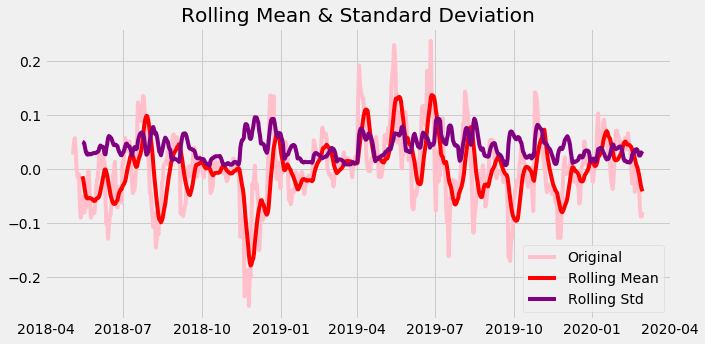

Results of Augment Dickey-Fuller Test:
Test Statistic                -6.930545e+00
p-value                        1.086962e-09
#Lags Used                     1.000000e+00
Number of Observations Used    6.660000e+02
Critical Value (1%)           -3.440207e+00
Critical Value (5%)           -2.865889e+00
Critical Value (10%)          -2.569086e+00
dtype: float64


In [114]:
#pass the adf test
btc_log_moving_avg_diff=btc_log_moving_avg_diff[11:]
adf_test(btc_log_moving_avg_diff)

Text(0.5, 1.0, 'First Diff')

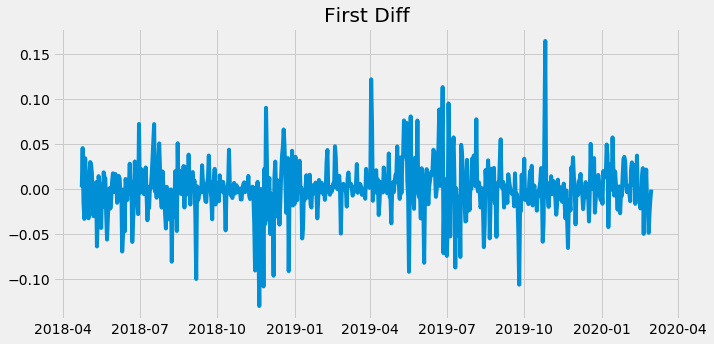

In [115]:
#first order difference
btc_log_diff = btc_log - btc_log.shift(periods=1)
plt.figure(figsize=(10,5))
plt.plot(btc_log_diff)
plt.title("First Diff")

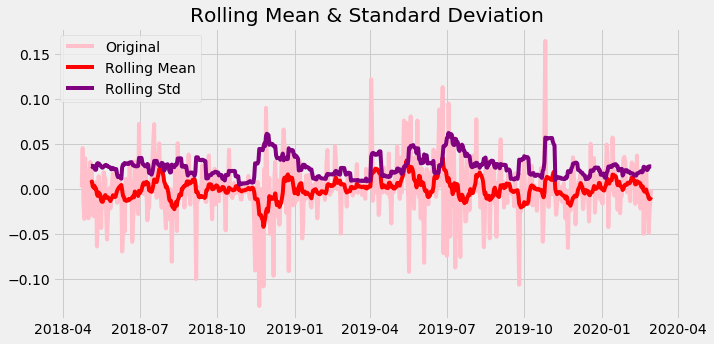

Results of Augment Dickey-Fuller Test:
Test Statistic                 -20.525080
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    677.000000
Critical Value (1%)             -3.440046
Critical Value (5%)             -2.865819
Critical Value (10%)            -2.569049
dtype: float64


In [116]:
#pass 5% test
btc_log_diff.dropna(inplace=True)
adf_test(btc_log_diff)

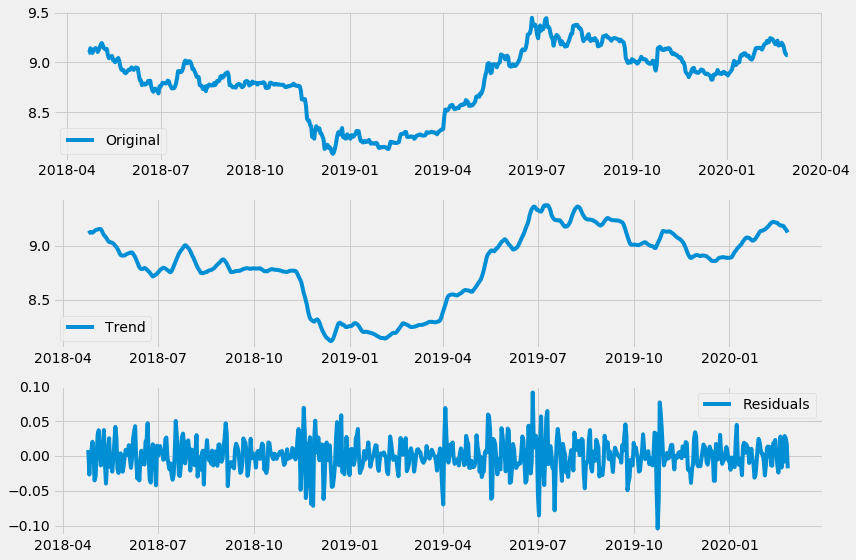

In [117]:
#decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12,8))
decomposition = seasonal_decompose(btc_log)
trend = decomposition.trend
residual = decomposition.resid

plt.subplot(311)
plt.plot(btc_log,label='Original')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

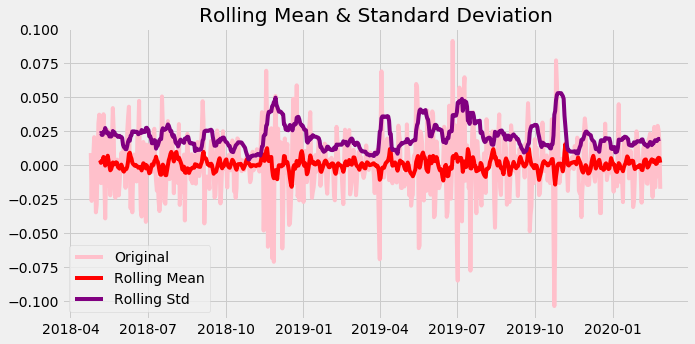

Results of Augment Dickey-Fuller Test:
Test Statistic                -1.107000e+01
p-value                        4.578732e-20
#Lags Used                     1.400000e+01
Number of Observations Used    6.580000e+02
Critical Value (1%)           -3.440327e+00
Critical Value (5%)           -2.865942e+00
Critical Value (10%)          -2.569114e+00
dtype: float64


In [118]:
#ADF test for the residual value
#stationary
btc_log_decompose = residual
btc_log_decompose.dropna(inplace=True)
adf_test(btc_log_decompose)

Text(0.5, 1.0, 'PACF')

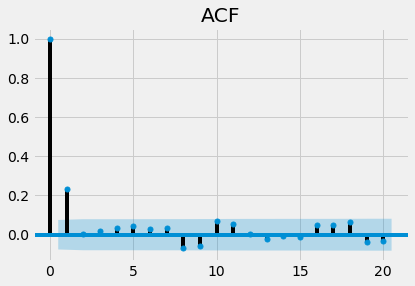

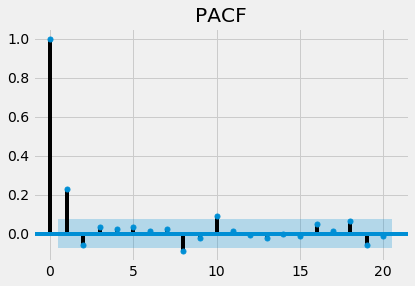

In [119]:
#autocorrelation
#partial autocorrelation
btc_acf=plot_acf(btc_log_diff,lags=20)
plt.title("ACF")

btc_pacf=plot_pacf(btc_log_diff,lags=20)
plt.title("PACF")

Text(0.5, 1.0, 'RSS:0.5181')

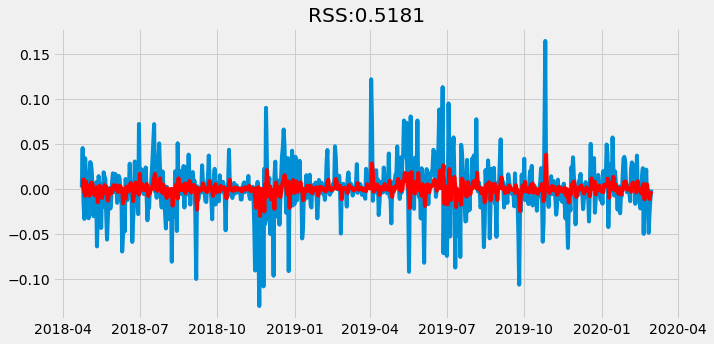

In [120]:
# AR，q=0
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(btc_log,order=(1,1,0)) 
results_AR = model.fit(disp=-1)
plt.figure(figsize=(10,5))
plt.plot(btc_log_diff)
plt.plot(results_AR.fittedvalues, color='red') 
plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-btc_log_diff)**2))

Text(0.5, 1.0, 'RSS: 0.5162')

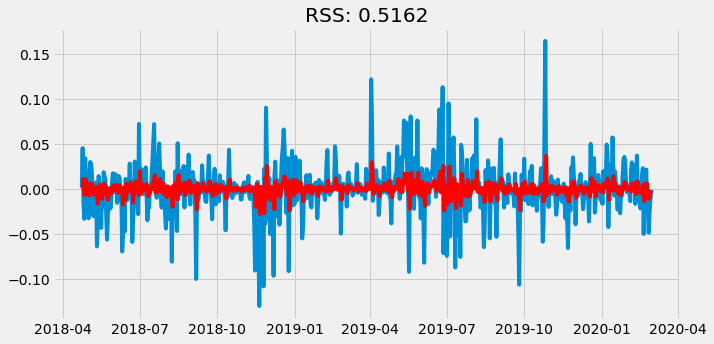

In [121]:
#MA p=0
model = ARIMA(btc_log,order=(0,1,1))
results_MA = model.fit(disp=-1)
plt.figure(figsize=(10,5))
plt.plot(btc_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-btc_log_diff)**2))

Text(0.5, 1.0, 'RSS: 0.5162')

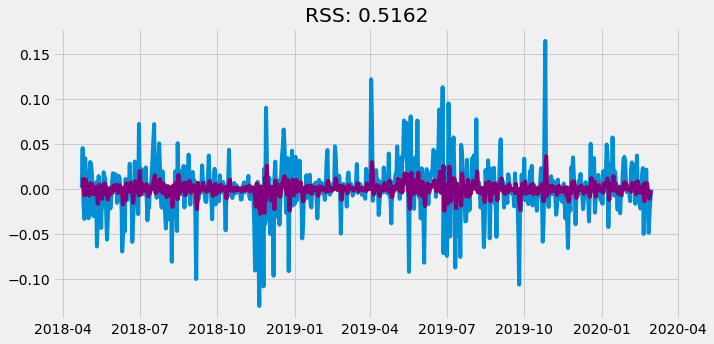

In [122]:
#ARIMA
model = ARIMA(btc_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1) 
plt.figure(figsize=(10,5))
plt.plot(btc_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.plot(results_ARIMA.predict(), color='purple')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-btc_log_diff)**2))

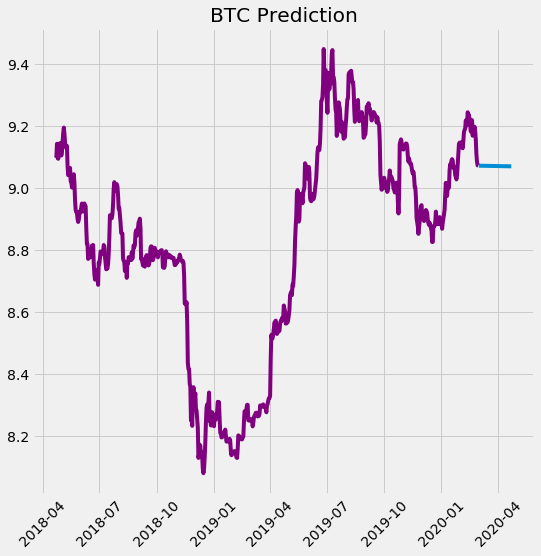

In [123]:
#prediction
pred=results_ARIMA.predict('20200301','20200422',dynamic=True,typ='levels')
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
plt.title("BTC Prediction")
plt.plot(pred)
plt.plot(btc_log,color="purple")

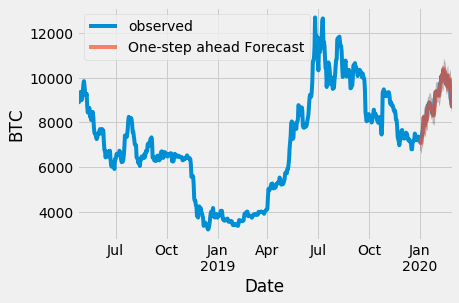

In [124]:
model=sm.tsa.statespace.SARIMAX(btc_train, order=(1,1,1))
result=model.fit()
pred = result.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = btc_train['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('BTC')
plt.legend()

plt.show()